In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
from sklearn.feature_selection import RFE
from sklearn.utils import resample
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

## Merging the files

In [2]:
#adding the external data as features
listings = pd.read_csv("C:\\Users\\rodri\\OneDrive\\Documentos\\GitHub\\Project-Data-Science\\#final\\Data_files\\listingsUpdateOut.csv")
neighb = pd.read_csv("C:\\Users\\rodri\\OneDrive\\Documentos\\GitHub\\Project-Data-Science\\#final\\Data_files\\neighbourhoods_update.csv", sep = ",")
main = pd.merge(listings, neighb, how="inner", on="neighbourhood_group")


#adding the polarity as feauture
sentiment= pd.read_csv("C:\\Users\\rodri\\OneDrive\\Documentos\\GitHub\\Project-Data-Science\\#final\\Data_files\\sentiment.csv")
sentiment= sentiment.rename(columns={"listing_id": "id"})
main2 = pd.merge(main, sentiment, how= "inner", on="id")

# Classification algorithms

In this sections, multiple types of algorithms were executed, to understand which one performs better

## Loogistic regression

In [3]:
datalog=main2[['price','minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'host_response_time',
       'host_response_rate', 'host_is_superhost', 'nr_of_bathrooms',
       'bedrooms', 'accommodates', 'review_scores_rating',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value','coefficient_of_location', 'purchase_power_pc', 'crime_pt',
       'population_density', 'other_touristic_accomodations', 'Polarity']]

In [6]:
#dependent variable --> binary
y= datalog[['host_is_superhost']]

#features selected to use, works better with just these
x = datalog[["number_of_reviews", 'coefficient_of_location', "nr_of_bathrooms", "bedrooms", "review_scores_rating", "purchase_power_pc", "crime_pt", "population_density", "host_response_rate", "Polarity"]]
x2=datalog[["review_scores_value","host_response_rate","calculated_host_listings_count", 'coefficient_of_location',"crime_pt","Polarity"]]

In [7]:
#Using statsmodel to create the logistic regression
logit_model=sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.613649
         Iterations 6
                             Results: Logit
Model:                 Logit              Pseudo R-squared:  0.072      
Dependent Variable:    host_is_superhost  AIC:               241478.4837
Date:                  2022-05-07 23:12   BIC:               241580.3800
No. Observations:      196740             Log-Likelihood:    -1.2073e+05
Df Model:              9                  LL-Null:           -1.3012e+05
Df Residuals:          196730             LLR p-value:       0.0000     
Converged:             1.0000             Scale:             1.0000     
No. Iterations:        6.0000                                           
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
number_of_reviews        0.0048   0.0001  78.2122 0

In [41]:
#Using sklearn to create the logistic regression
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

C:\Users\rodri\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\rodri\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [42]:
#taking a look at the coeficients obtained
logreg.coef_

array([[ 0.00484669, -0.17973353, -0.12635966, -0.07864567,  1.03719951,
        -0.03579912, -0.09036863,  0.00133103,  0.29996611,  0.38204126]])

In [43]:
#Getting the accuracy of the model
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.66


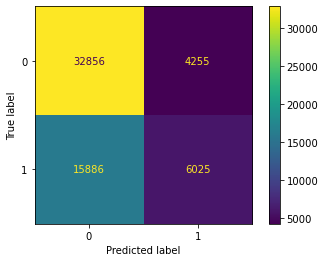

In [33]:
#ploting a confusion matrix to take a look at false positive and false negative
plot_confusion_matrix(logreg,
                     X_test,
                     y_test,
                     values_format='d')

In [36]:
#To understand the precision and recall of the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.89      0.77     37111
           1       0.59      0.27      0.37     21911

    accuracy                           0.66     59022
   macro avg       0.63      0.58      0.57     59022
weighted avg       0.64      0.66      0.62     59022



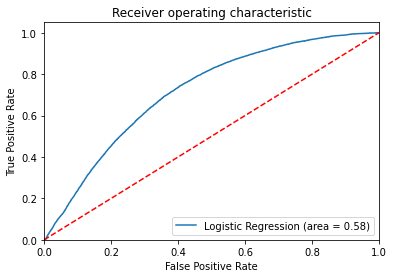

In [10]:
#Plotting a roc curve to have a better visualization of how good our classifier is
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

## SVM

SVM algorithm works better with small datasets, therefore we need to perform a resample by downsampling the dataset, 1000 data was collected from each binary outcome, superhost or notsuperhost.

In [39]:
len(datalog)

196740

In [40]:
#resampling 
datalogSuperHost=datalog[datalog["host_is_superhost"]== 1]
datalogHost=datalog[datalog["host_is_superhost"]== 0]

In [41]:
#downsample
datalogSuperHost_downsample= resample(datalogSuperHost, replace= False, n_samples= 1000, random_state=42)



datalogHost_downsample= resample(datalogHost, replace= False, n_samples= 1000, random_state=42)



In [42]:
#concacenating 
datalog_downsample= pd.concat([datalogHost_downsample,datalogSuperHost_downsample])
len(datalog_downsample)

2000

In [43]:
datalog_downsample

price  minimum_nights  number_of_reviews  reviews_per_month  \
46999     161               1                 62               0.97   
96426      61               2                122               2.95   
137801    110               2                 11               0.41   
40072      61               5                131               1.94   
100822     88               3                 34               0.86   
...       ...             ...                ...                ...   
75861      75               2                 36               0.78   
35129      75               3                  7               0.10   
49240      72               1                199               3.23   
66358      23               2                106               2.07   
40407      33               2                174               2.59   

        calculated_host_listings_count  availability_365  \
46999                               38               317   
96426                                1               346   
137801                              10                65   
40072                                2                 6   
100822                              24               350   
...                                ...               ...   
75861                               30               214   
35129                                2               324   
49240                                3                 0   
66358                                4               123   
40407                                1                81   

        number_of_reviews_ltm  host_response_time  host_response_rate  \
46999                       3                   1                0.98   
96426                      24                   1                1.00   
137801                      4                   1                1.00   
40072                       9                   3                0.50   
100822                      0                   1                1.00   
...                       ...                 ...                 ...   
75861                       7                   1                1.00   
35129                       4                   1                1.00   
49240                       0                   1                1.00   
66358                       7                   1                1.00   
40407                      27                   1                1.00   

        host_is_superhost  ...  review_scores_checkin  \
46999                   0  ...                   4.61   
96426                   0  ...                   4.78   
137801                  0  ...                   4.90   
40072                   0  ...                   4.85   
100822                  0  ...                   4.03   
...                   ...  ...                    ...   
75861                   1  ...                   4.94   
35129                   1  ...                   4.86   
49240                   1  ...                   4.89   
66358                   1  ...                   4.83   
40407                   1  ...                   4.93   

        review_scores_communication  review_scores_location  \
46999                          4.69                    4.86   
96426                          4.89                    4.72   
137801                         5.00                    4.90   
40072                          4.86                    4.91   
100822                         4.68                    4.79   
...                             ...                     ...   
75861                          4.83                    4.83   
35129                          5.00                    4.57   
49240                          4.97                    4.63   
66358                          4.86                    4.71   
40407                          4.95                    4.78   

        review_scores_value  coefficient_of_location  purchase_power_pc  \
46999                  4.44             

In [44]:
x1= datalog_downsample.drop("host_is_superhost", axis=1) #performs better with all the features
y1= datalog_downsample["host_is_superhost"]

In [72]:
from sklearn import svm

In [73]:
X1_train, X1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.3, random_state=42)
X1_train_scaled=scale(X1_train)
X1_test_scaled=scale(X1_test)

In [74]:
clf = svm.SVC(random_state=42) 
clf.fit(X1_train_scaled, y1_train)

SVC(random_state=42)

In [75]:
from sklearn import metrics
y_pred1 = clf.predict(X1_test_scaled)
print("Accuracy:",metrics.accuracy_score(y1_test, y_pred1))

Accuracy: 0.7616666666666667


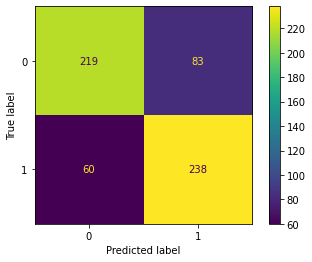

In [76]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf,
                     X1_test_scaled,
                     y1_test,
                     values_format='d')

In [84]:
#finding the optimum parameters to increase the performance of svm algorithm
param_grid=[
    {'C': [0.5,1,10,100],
     "gamma": ['scale',1,0.1,0.01,0.001, 0.0001],
     'kernel': ['rbf', 'poly','sigmoid']}
]

In [85]:
#Uing grid search to find best paramters
optimal_params= GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=0)

In [86]:
optimal_params.fit(X1_train_scaled,y1_train)
print(optimal_params.best_params_)

{'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}


In [81]:
clf_svm= svm.SVC(random_state=42, C=10, gamma= 0.01)
clf_svm.fit(X1_train_scaled,y1_train)

SVC(C=10, gamma=0.01, random_state=42)

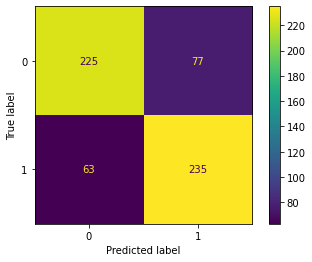

In [82]:
plot_confusion_matrix(clf_svm,
                     X1_test_scaled,
                     y1_test,
                     values_format='d')

In [83]:
#only improves accuracy by 0.05%
y_pred2 = clf_svm.predict(X1_test_scaled)
print("Accuracy:",metrics.accuracy_score(y1_test, y_pred2))

Accuracy: 0.7666666666666667


## PCA

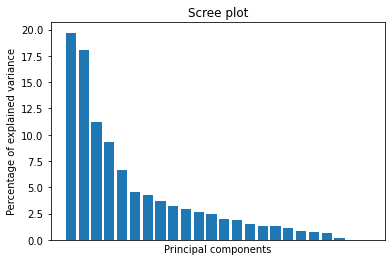

In [29]:
#Doing PCA
pca= PCA()
X_train_pca=pca.fit_transform(X1_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels= [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1,len(per_var)+1), height=per_var)
plt.tick_params(
    axis="x",
    which="both",
    bottom= False,
    top= False,
    labelbottom= False)

plt.ylabel("Percentage of explained variance")
plt.xlabel("Principal components")
plt.title("Scree plot")
plt.show()


In [30]:
#using pca in SVM
train_pca1_coords= X_train_pca[:, 0]
train_pca2_coords= X_train_pca[:, 1]

#scaling the data
pca_train_scaled= scale(np.column_stack((train_pca1_coords,train_pca2_coords)))

In [31]:
#finding the best paramters
param_grid=[
    {'C': [0.5,1,10,100],
     "gamma": ['scale',1,0.1,0.01,0.001, 0.0001],
     'kernel': ['rbf']}
]

In [32]:
optimal_params= GridSearchCV(
    svm.SVC(),
    param_grid,
    cv=5,
    scoring="accuracy",
    verbose=0)

In [33]:
optimal_params.fit(pca_train_scaled,y1_train)
print(optimal_params.best_params_)

{'C': 0.5, 'gamma': 'scale', 'kernel': 'rbf'}


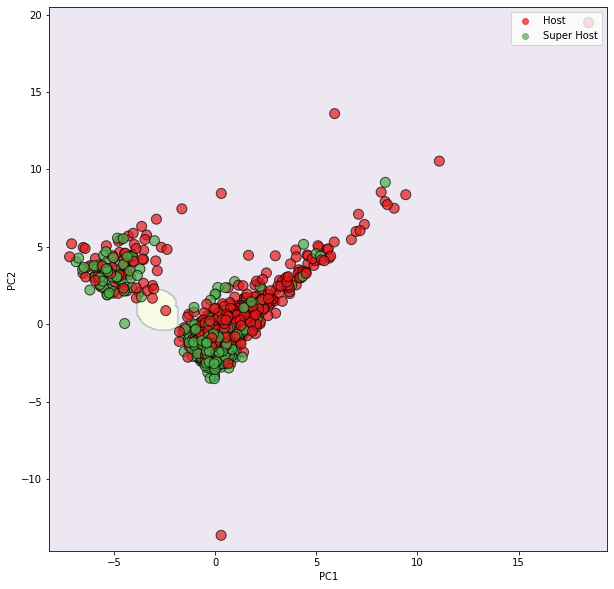

In [34]:
#plotting the result in a two dimension graph
import matplotlib.colors as colors
clf_svm = svm.SVC(random_state=42, C=0.5, gamma= "scale")
clf_svm.fit(pca_train_scaled,y1_train)

X_test_pca =pca.transform(X1_train_scaled)
test_pca1_coords= X_test_pca[:, 0]
test_pca2_coords= X_test_pca[:, 1]


x_min= test_pca1_coords.min() -1
x_max= test_pca1_coords.max() +1

y_min= test_pca2_coords.min() -1
y_max= test_pca2_coords.max() +1

xx, yy= np.meshgrid(np.arange(start=x_min, stop=x_max, step= 0.1),
                   np.arange(start=y_min, stop= y_max, step=0.1))

Z = clf_svm.predict(np.column_stack((xx.ravel(), yy.ravel())))

Z = Z.reshape(xx.shape)
fig, ax= plt.subplots(figsize=(10,10))
ax.contourf(xx, yy, Z, alpha= 0.1)

cmap=colors.ListedColormap(['#e41a1c','#4daf4a'])

scatter= ax.scatter(test_pca1_coords, test_pca2_coords, c=y1_train,
                   cmap=cmap,
                   s=100,
                   edgecolors='k',
                   alpha=0.7)
legend= ax.legend(scatter.legend_elements()[0],
                 scatter.legend_elements()[1],
                 loc='upper right')

legend.get_texts()[0].set_text("Host")
legend.get_texts()[1].set_text("Super Host")

ax.set_ylabel('PC2')
ax.set_xlabel('PC1')
plt.show()

## Decision tree

In [21]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

In [54]:
#splitting dat
X2_train, X2_test, y2_train, y2_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [22]:
#finding the best depth level
max_depth_range = list((3, 5,10,15,20,25,30))
# List to store the accuracy for each value of max_depth:
accuracy = []
for depth in max_depth_range:
    
    clf = DecisionTreeClassifier(max_depth = depth, 
                             random_state = 0)
    clf.fit(X2_train, y2_train)
    score = clf.score(X2_test, y2_test)
    accuracy.append(score)

In [23]:
accuracy

[0.7234421063332317,
 0.7431296804581342,
 0.7897394191996204,
 0.8687099725526075,
 0.9427840466266816,
 0.9784825997085832,
 0.9915455253973094]

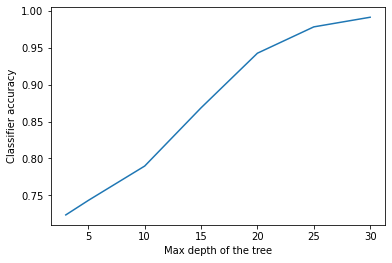

In [24]:
#ploting the depth/ accuracy relation for visualization purposes 
plt.plot(max_depth_range,accuracy)
plt.xlabel("Max depth of the tree")
plt.ylabel("Classifier accuracy")
plt.show()

In [56]:
#creating the classifier
clf = DecisionTreeClassifier()
clf = clf.fit(X2_train,y2_train)

In [57]:
#classifier prediction
y_pred3 = clf.predict(X2_test)
print("Accuracy:",metrics.accuracy_score(y2_test, y_pred3))

Accuracy: 0.9973230320897293


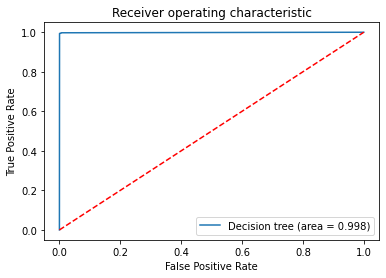

In [70]:
Tree_roc_auc=roc_auc_score(y2_test, clf.predict_proba(X2_test)[:,1])

fpr, tpr, _ = roc_curve(y2_test, clf.predict_proba(X2_test)[:,1])

plt.clf()
plt.plot(fpr, tpr,label='Decision tree (area = %0.3f)' % Tree_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [32]:
#Visualizing the classification tree
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

feature_cols=['number_of_reviews', 'coefficient_of_location', 'nr_of_bathrooms',
       'bedrooms', 'review_scores_rating', 'purchase_power_pc',
       'crime_rate_pc', 'population_density', 'host_response_rate',
       'Polarity']
feature_cols2=["review_scores_value","host_response_rate",
              "calculated_host_listings_count", 'coefficient_of_location',"crime_rate_pc","Polarity"]
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols2,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

#graph.write_png('superhost.png')
Image(graph.create_png())


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.256339 to fit



In [33]:
#Pruning the tree, so it becomes less complex
clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
clf = clf.fit(X2_train,y2_train)


y_pred4 = clf.predict(X2_test)


print("Accuracy:",metrics.accuracy_score(y2_test, y_pred4))

Accuracy: 0.7234421063332317


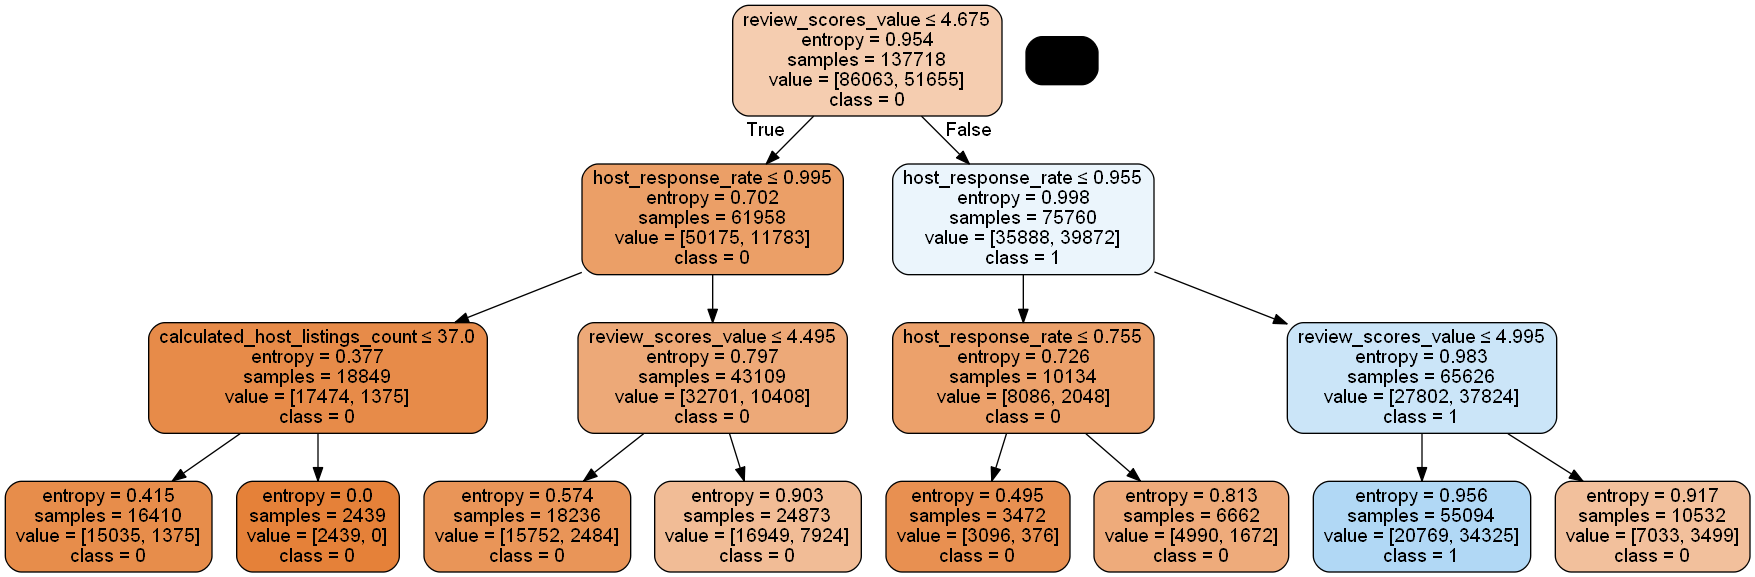

In [34]:
#Visualizing the prunned tree
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols2,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('prunnedtree.png')
Image(graph.create_png())

## Random forest

Implementing random forest to better suit the data set and avoid over fitting

In [50]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std

In [47]:
model = RandomForestClassifier()
#3 repeats and 10 folds
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [48]:
n_scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

In [51]:
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.997 (0.000)
